# Data loading

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport

from ev_simulation_model.data import load_norway_residential_data

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
CWD = Path("/Users/phipag/Git/powertac/ev-simulation-model")

In [3]:
raw_df = load_norway_residential_data(CWD / "data" / "norway_residential" / "Dataset 1_EV charging reports.csv")

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   object        
 4   Shared_ID          1412 non-null   object        
 5   Start_plugin       6878 non-null   datetime64[ns]
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   datetime64[ns]
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   object        
 12  weekdays_plugin    6878 non-null   object        
 13  Plugin_category    6878 non-null   object        
 14  Duration

In [5]:
raw_df.describe()

,session_ID,Start_plugin_hour,End_plugout_hour,El_kWh,Duration_hours
count,6878.000000,6878.000000,6844.000000,6878.000000,6844.000000
mean,3439.500000,16.325240,12.546902,12.720744,11.504440
std,1985.651908,4.363108,5.256756,11.787938,14.148168
min,1.000000,0.000000,0.000000,0.010000,0.003333
25%,1720.250000,15.000000,7.000000,5.200000,2.789028
50%,3439.500000,17.000000,12.000000,9.050000,10.026250
75%,5158.750000,19.000000,17.000000,16.090000,15.221181
max,6878.000000,23.000000,23.000000,80.860000,255.029444


# Raw data exploration

## Automatic with `pandas_profiling`

Uncomment this markdown to re-run the report generation:
```python
profile = ProfileReport(raw_df, explorative=True)
profile.to_file("exploration_report.html")
```

## Manual exploration

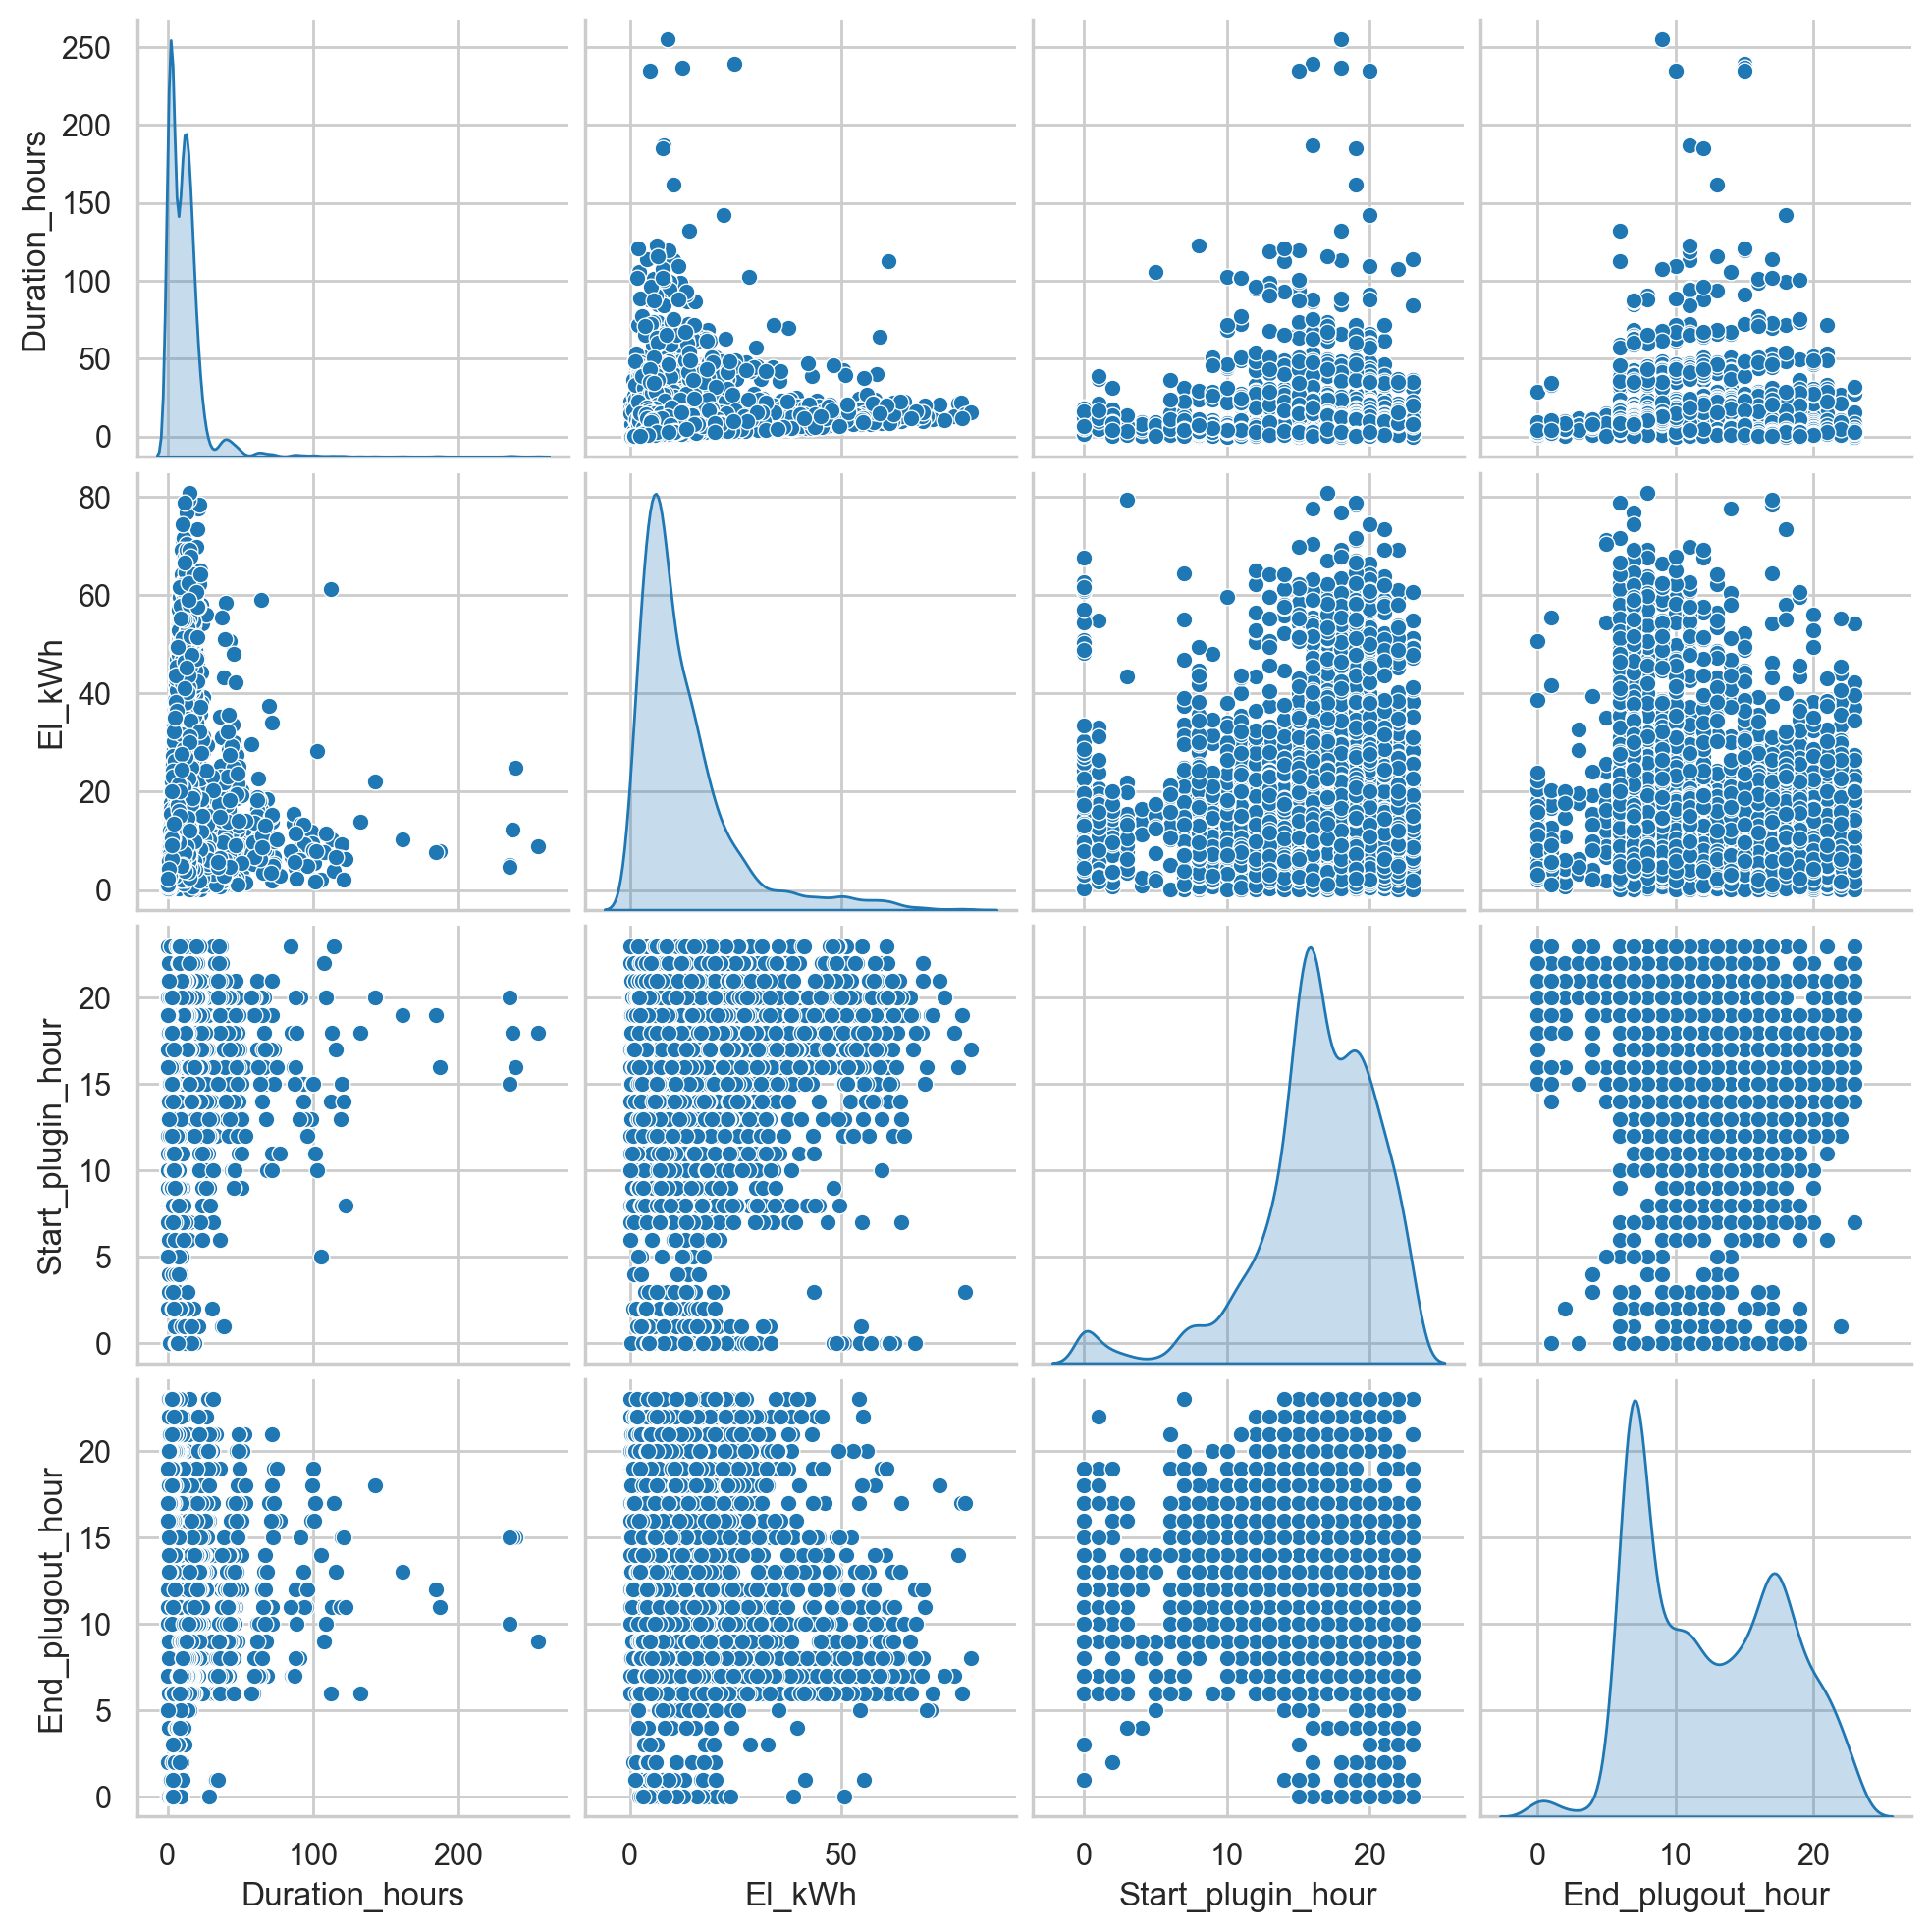

In [6]:
sns.pairplot(
    data=raw_df,
    vars=["Duration_hours", "El_kWh", "Start_plugin_hour", "End_plugout_hour"],
    diag_kind="kde",
);

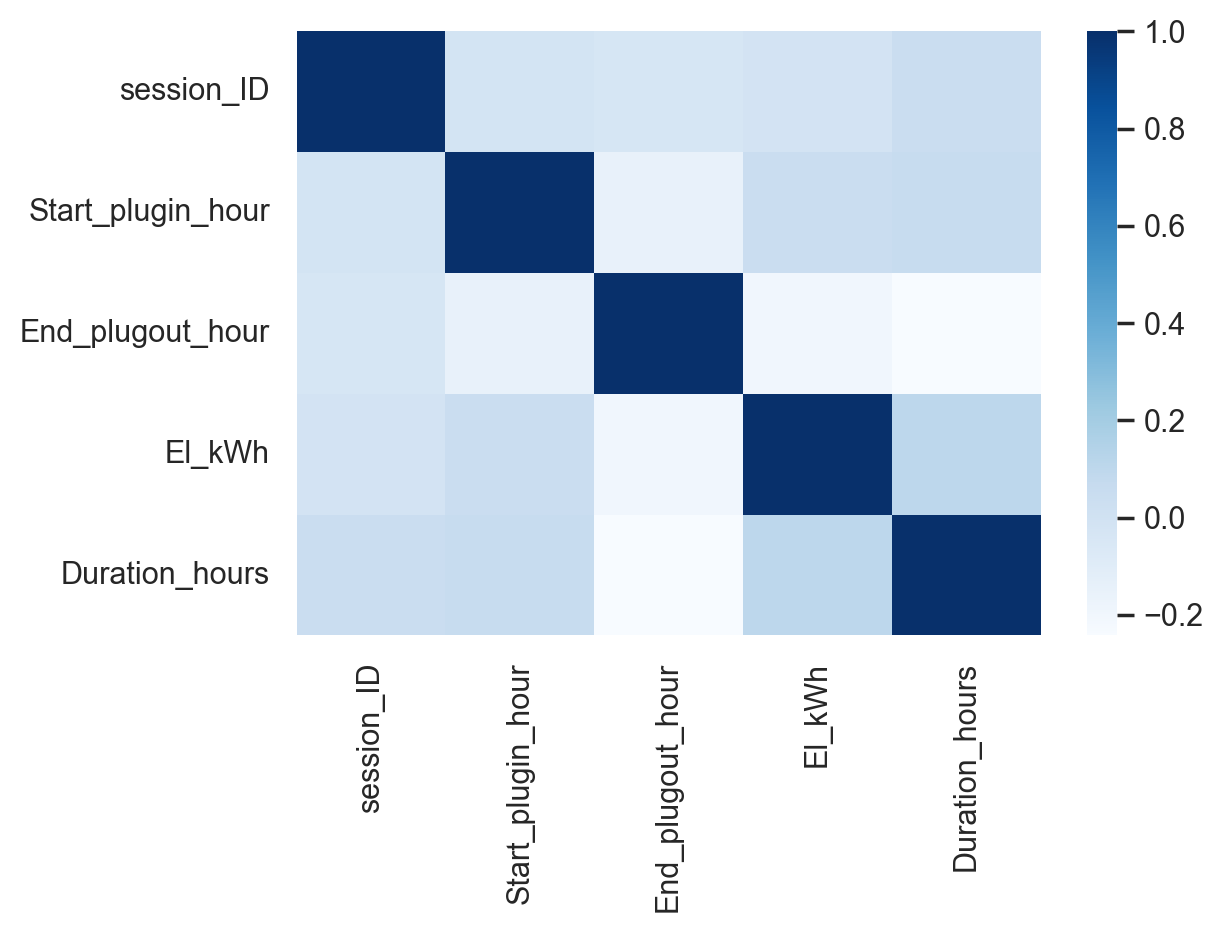

In [7]:
fig, ax = plt.subplots()
sns.heatmap(raw_df.corr(), cmap="Blues", ax=ax);

# Charging pattern exploration

## Daily pattern

In [8]:
charging_df = raw_df.melt(
    id_vars=["Start_plugin_hour", "End_plugout_hour", "weekdays_plugin"],
    value_vars=["Duration_hours", "El_kWh"],
)
charging_df

,Start_plugin_hour,End_plugout_hour,weekdays_plugin,variable,value
0,10,10.0,Friday,Duration_hours,0.050000
1,10,10.0,Friday,Duration_hours,0.136667
2,11,19.0,Friday,Duration_hours,8.216389
3,16,16.0,Saturday,Duration_hours,24.419722
4,22,23.0,Monday,Duration_hours,0.970556
...,...,...,...,...,...
13751,17,22.0,Friday,El_kWh,13.430000
13752,18,21.0,Friday,El_kWh,9.100000
13753,19,20.0,Friday,El_kWh,4.280000
13754,19,19.0,Friday,El_kWh,2.310000


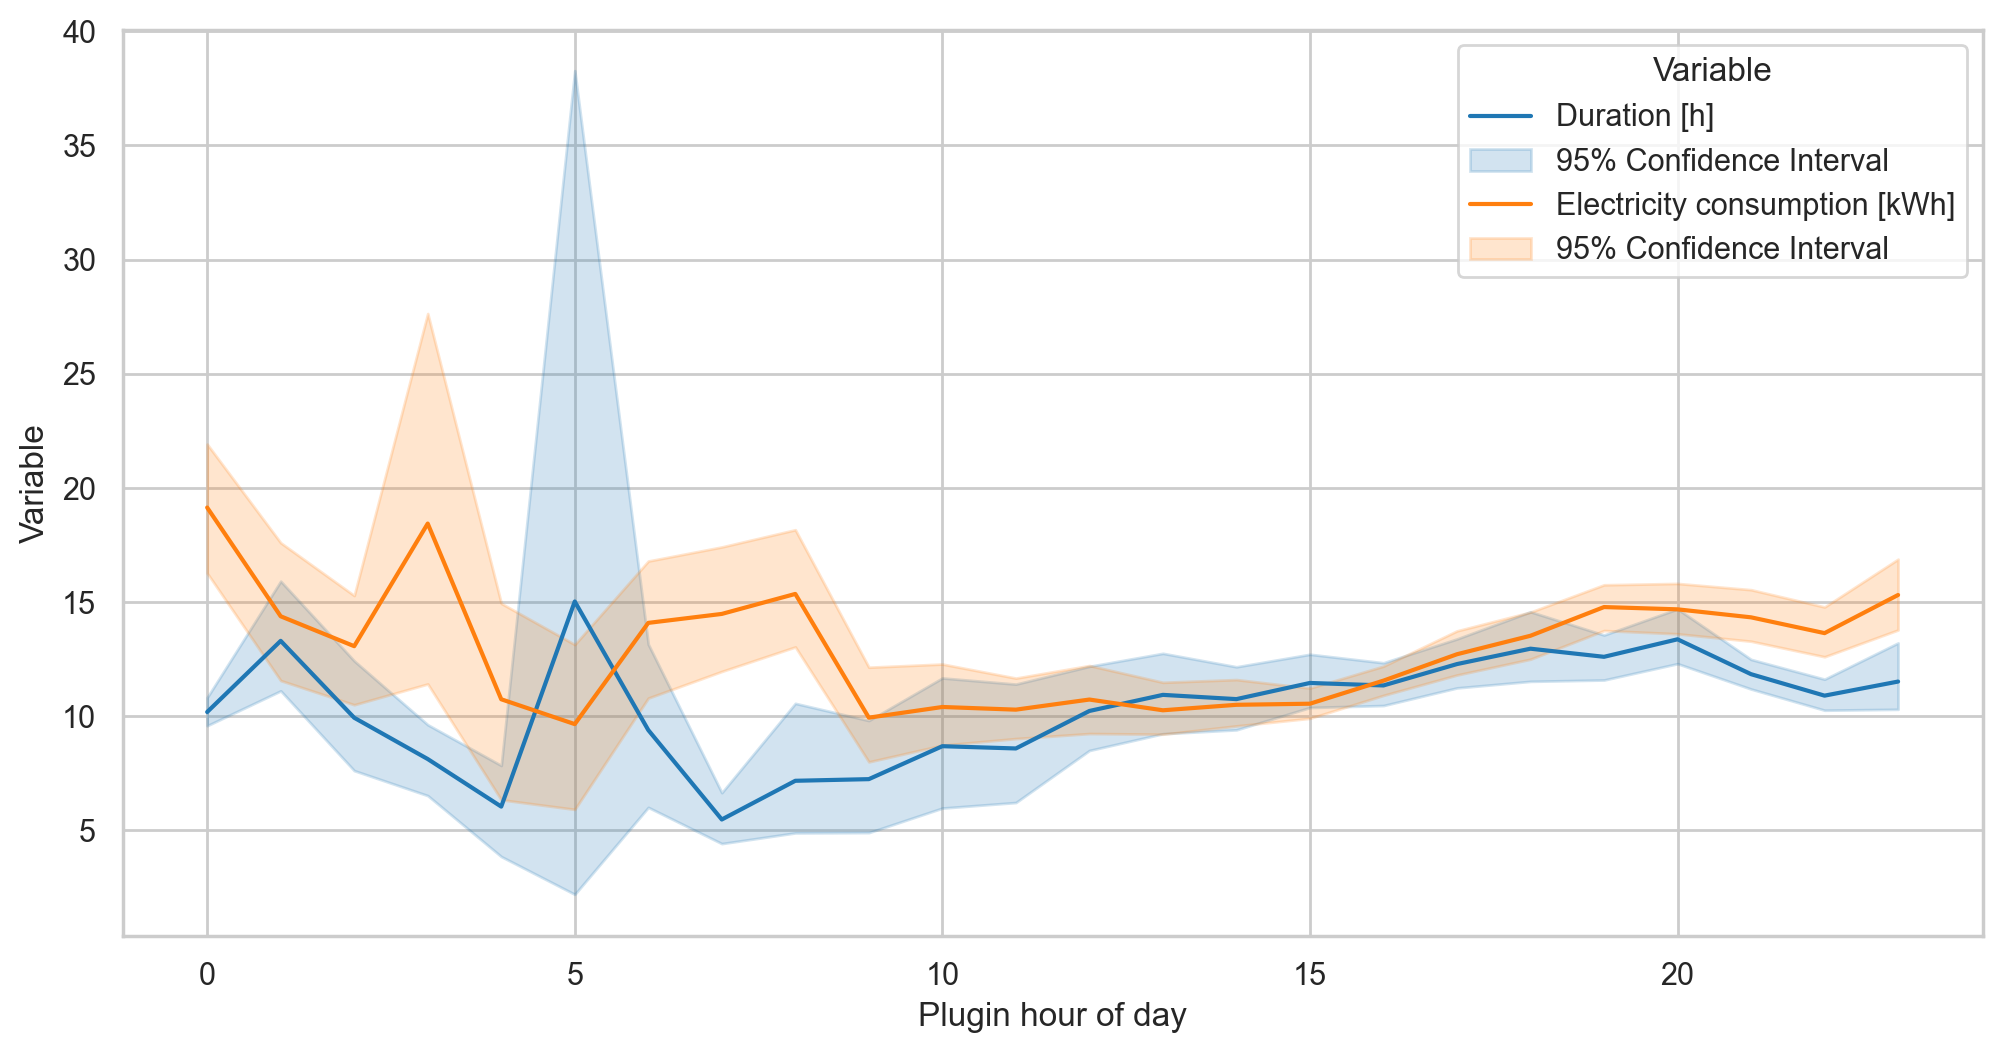

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="Start_plugin_hour", y="value", data=charging_df, hue="variable", ax=ax)
ax.set_xlabel("Plugin hour of day")
ax.set_ylabel("Variable")
ax.legend(
    title="Variable",
    labels=[
        "Duration [h]",
        "95% Confidence Interval",
        "Electricity consumption [kWh]",
        "95% Confidence Interval",
    ],
);

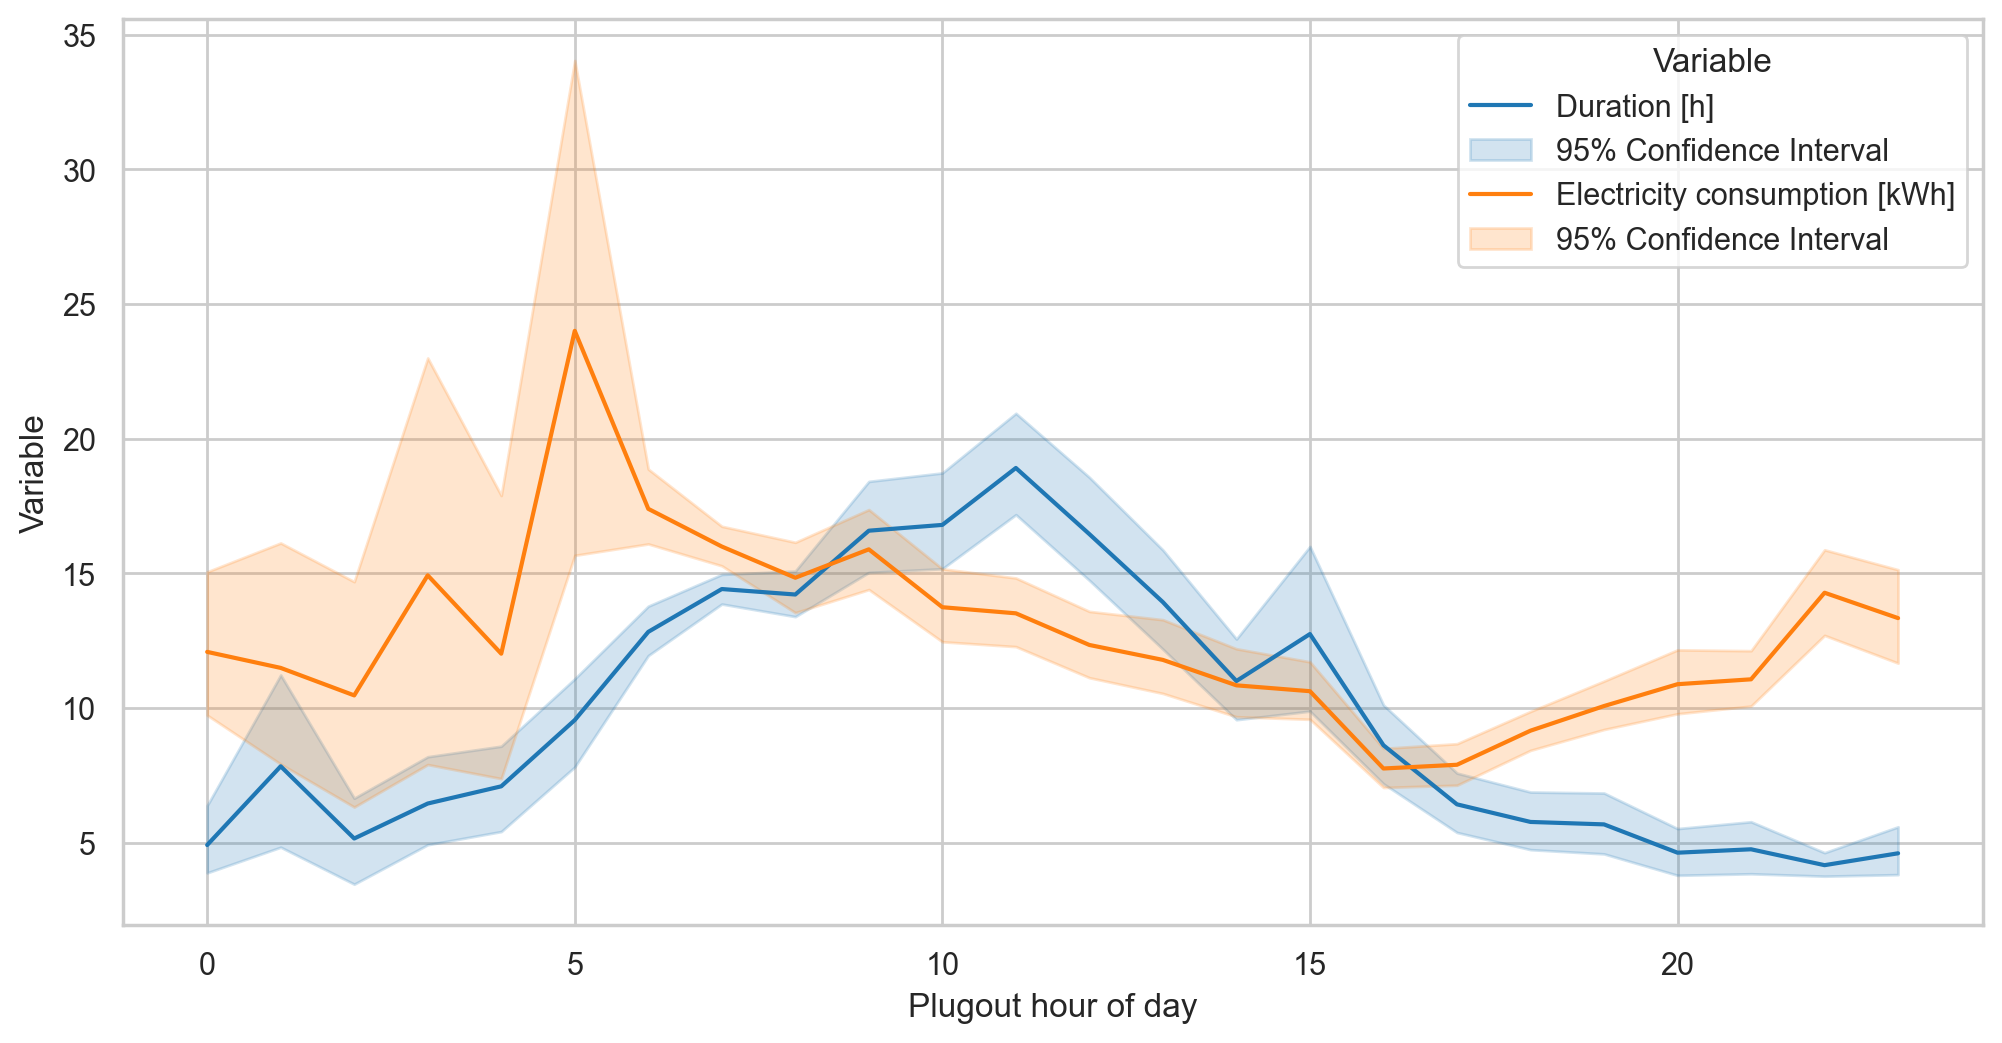

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="End_plugout_hour", y="value", data=charging_df, hue="variable", ax=ax)
ax.set_xlabel("Plugout hour of day")
ax.set_ylabel("Variable")
ax.legend(
    title="Variable",
    labels=[
        "Duration [h]",
        "95% Confidence Interval",
        "Electricity consumption [kWh]",
        "95% Confidence Interval",
    ],
);

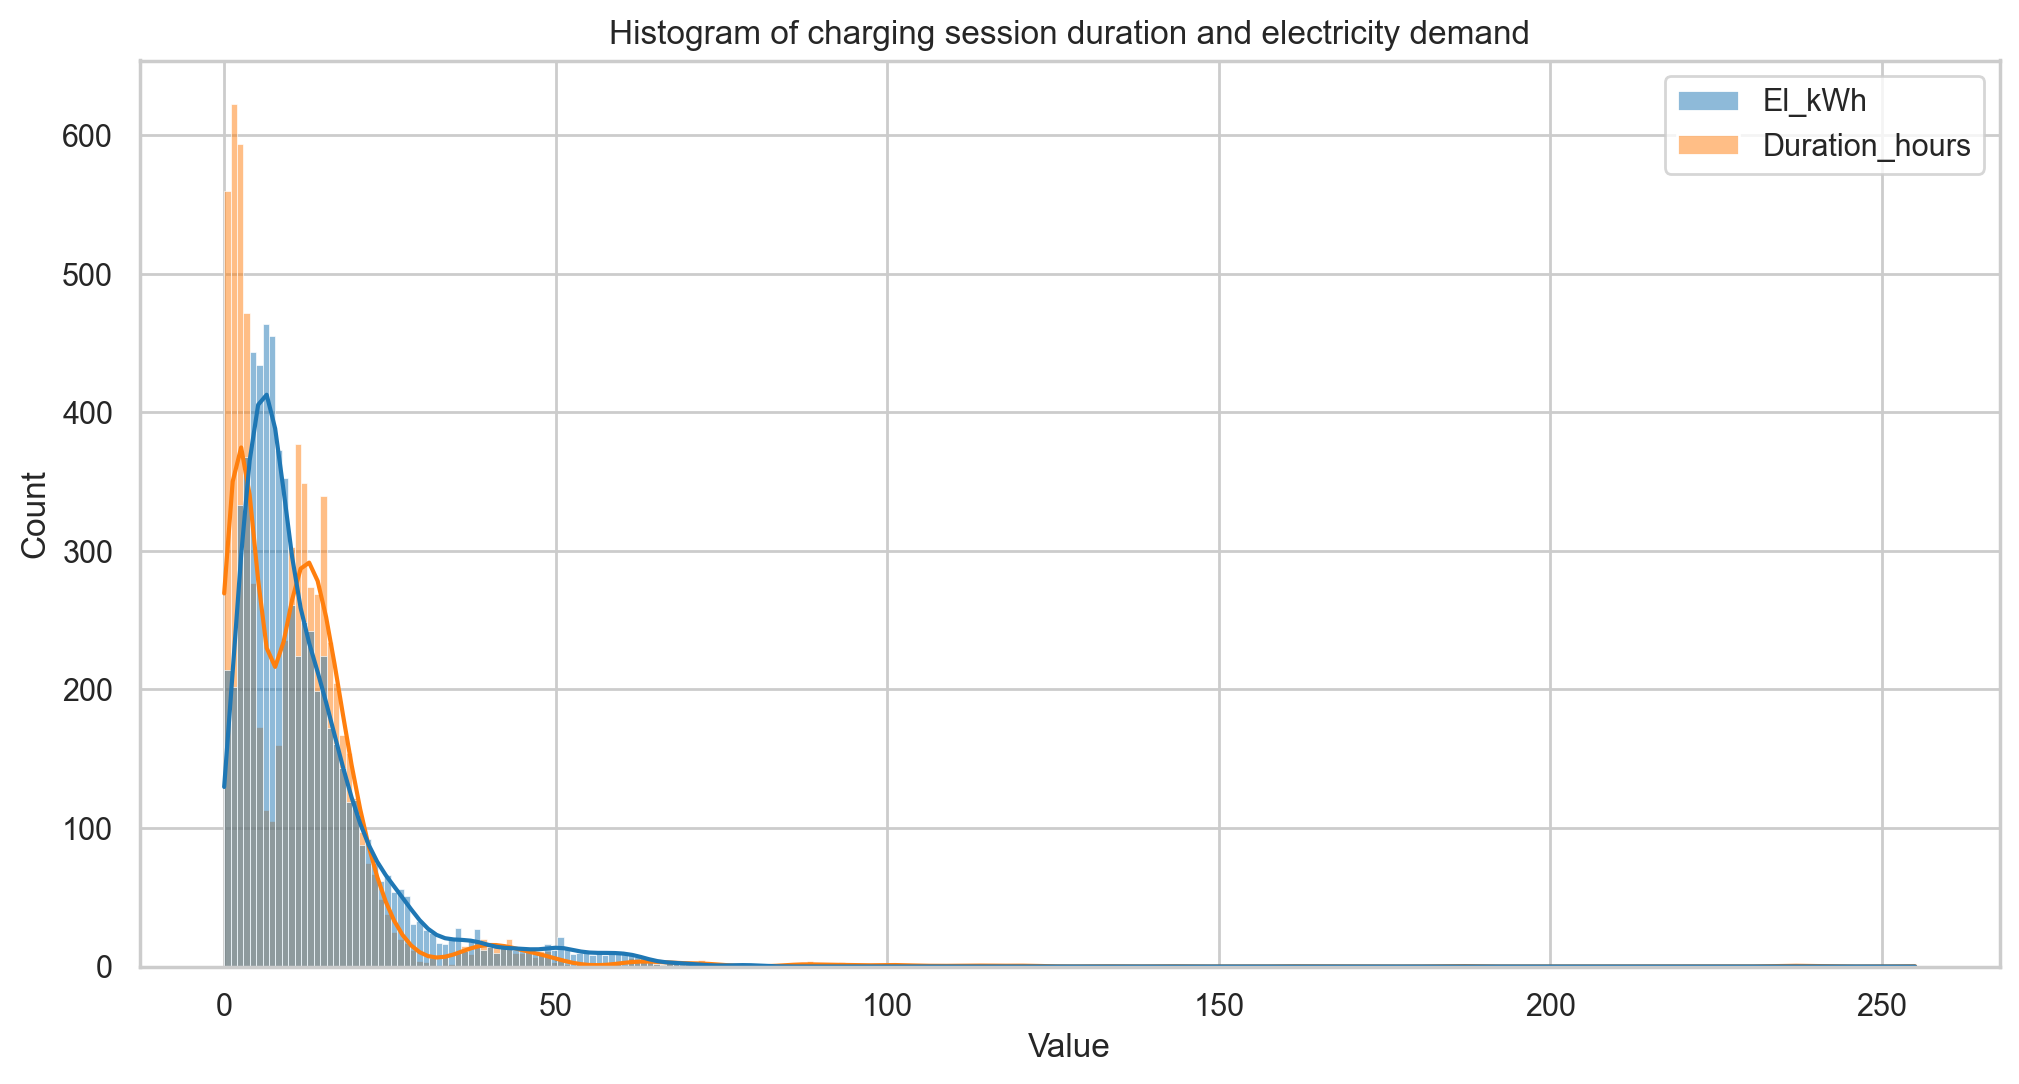

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(raw_df[["El_kWh", "Duration_hours"]], kde=True, ax=ax)
ax.set_xlabel("Value")
ax.set_title("Histogram of charging session duration and electricity demand");

## Weekly pattern

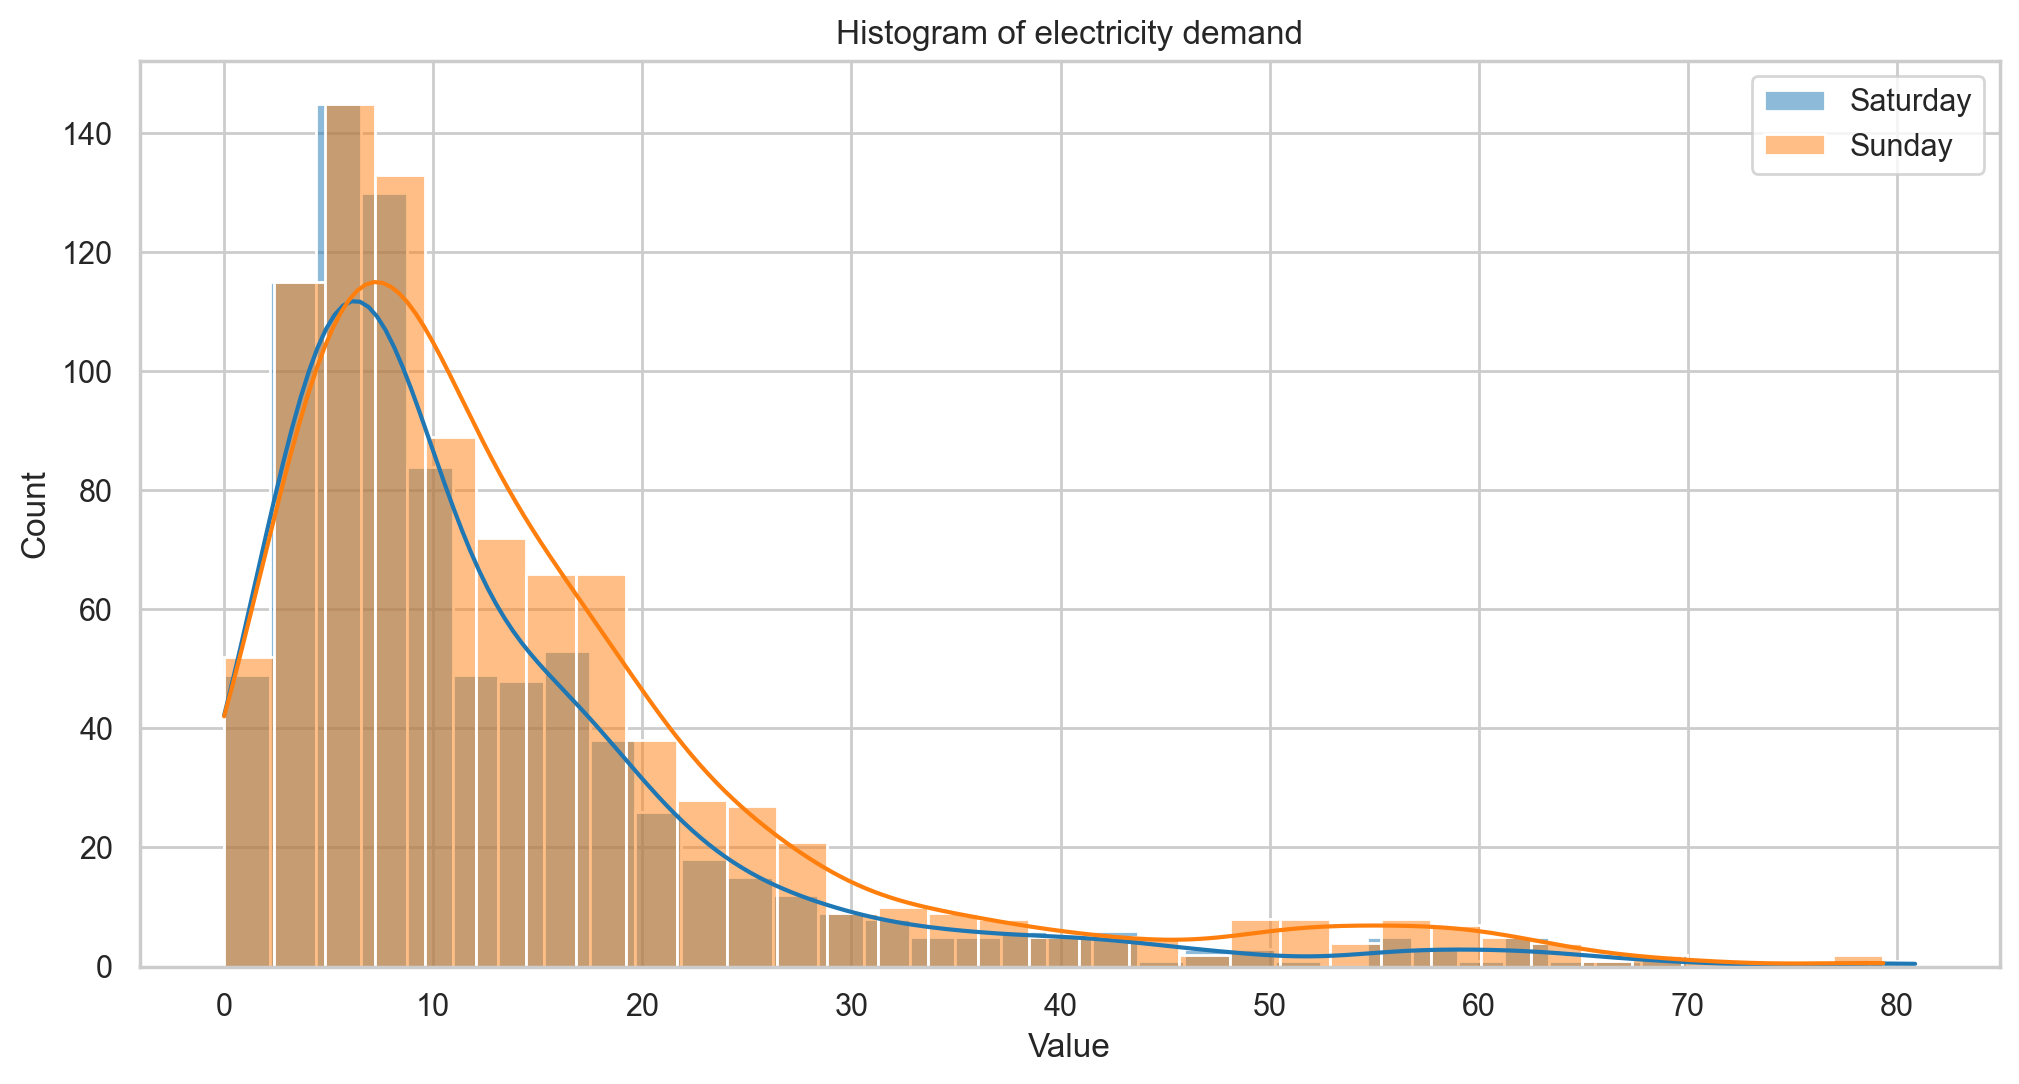

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    raw_df[raw_df["weekdays_plugin"] == "Saturday"]["El_kWh"], kde=True, ax=ax, color="#1f77b4", label="Saturday"
)
sns.histplot(raw_df[raw_df["weekdays_plugin"] == "Sunday"]["El_kWh"], kde=True, ax=ax, color="#ff7f0e", label="Sunday")
ax.set_xlabel("Value")
ax.set_title("Histogram of electricity demand")
ax.legend();

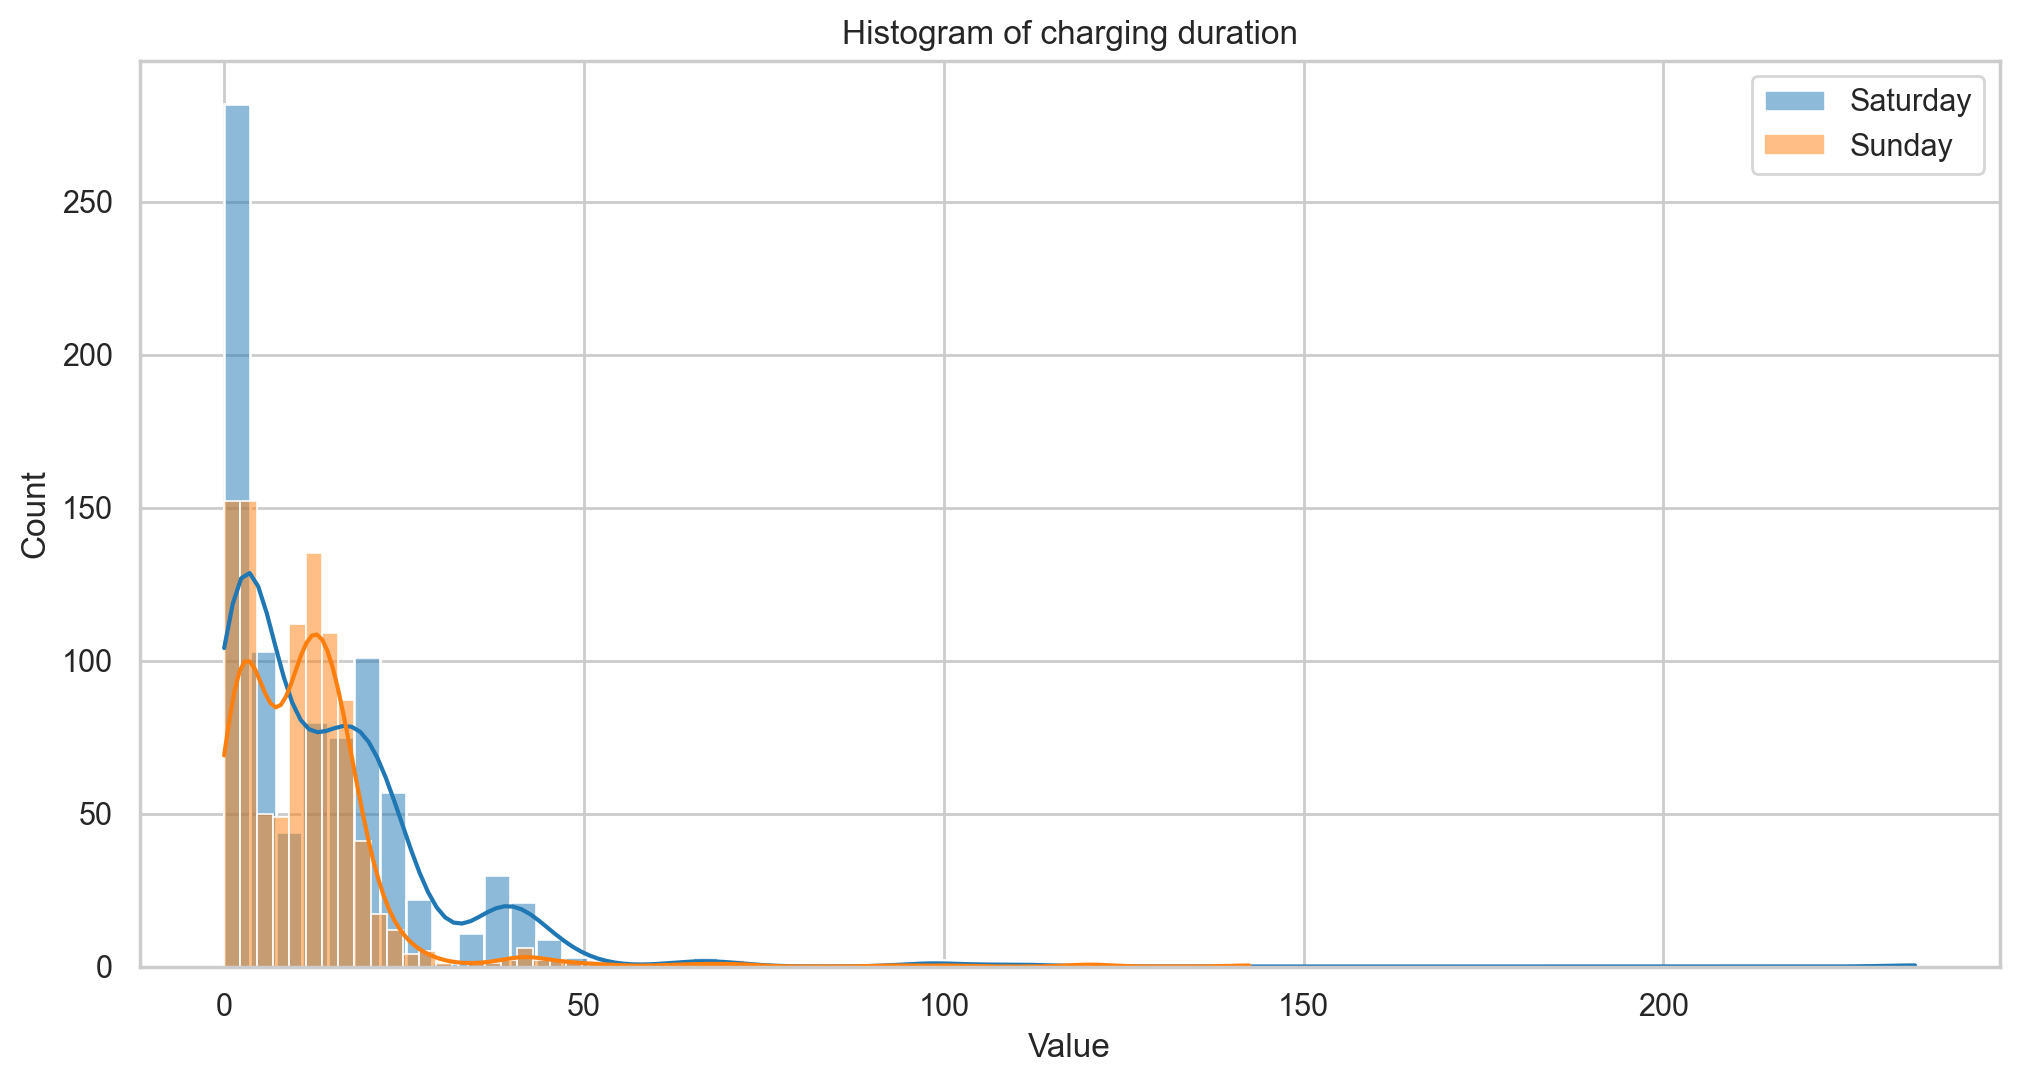

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    raw_df[raw_df["weekdays_plugin"] == "Saturday"]["Duration_hours"],
    kde=True,
    ax=ax,
    color="#1f77b4",
    label="Saturday",
)
sns.histplot(
    raw_df[raw_df["weekdays_plugin"] == "Sunday"]["Duration_hours"], kde=True, ax=ax, color="#ff7f0e", label="Sunday"
)
ax.set_xlabel("Value")
ax.set_title("Histogram of charging duration")
ax.legend();

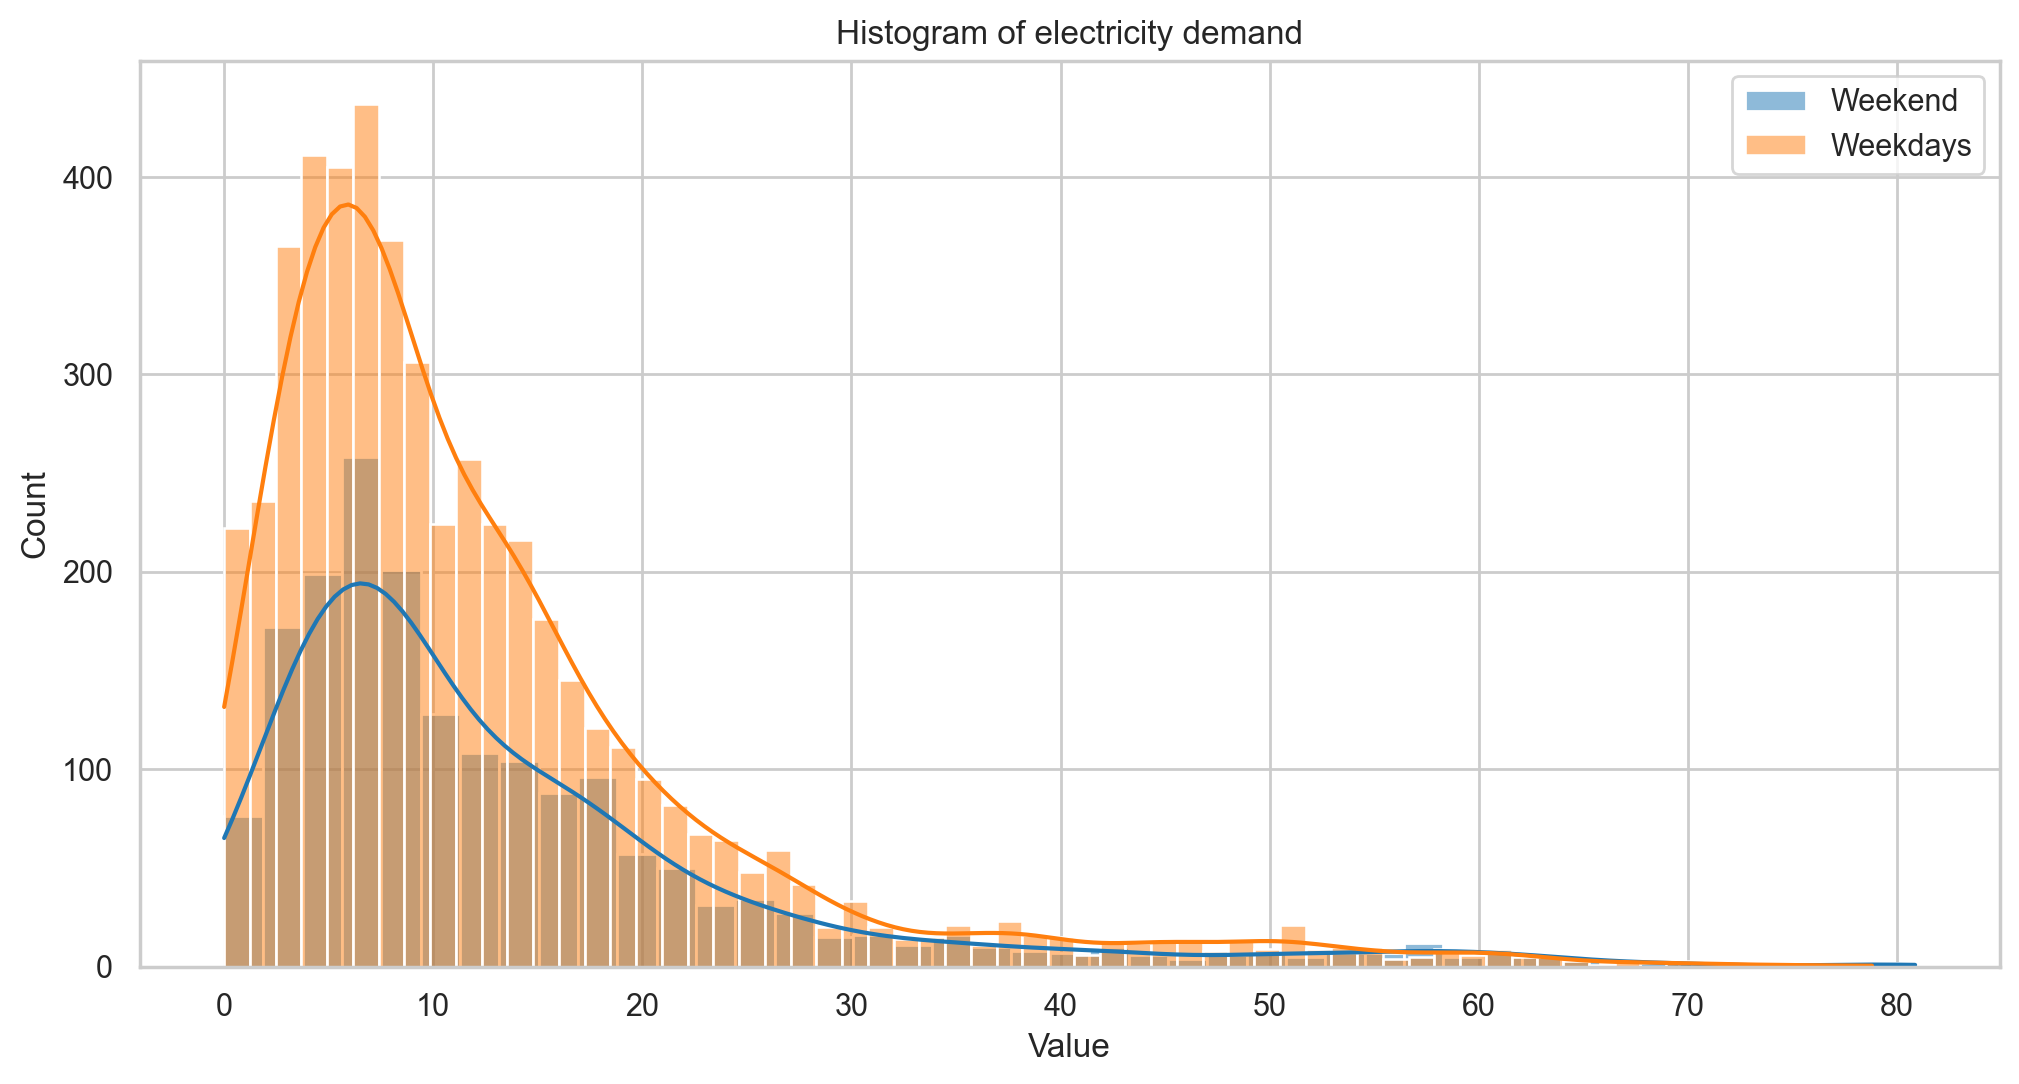

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    raw_df[(raw_df["weekdays_plugin"] == "Saturday") | (raw_df["weekdays_plugin"] == "Sunday")]["El_kWh"],
    kde=True,
    ax=ax,
    color="#1f77b4",
    label="Weekend",
)
sns.histplot(
    raw_df[~(raw_df["weekdays_plugin"] == "Saturday") & ~(raw_df["weekdays_plugin"] == "Sunday")]["El_kWh"],
    kde=True,
    ax=ax,
    color="#ff7f0e",
    label="Weekdays",
)
ax.set_xlabel("Value")
ax.set_title("Histogram of electricity demand")
ax.legend();

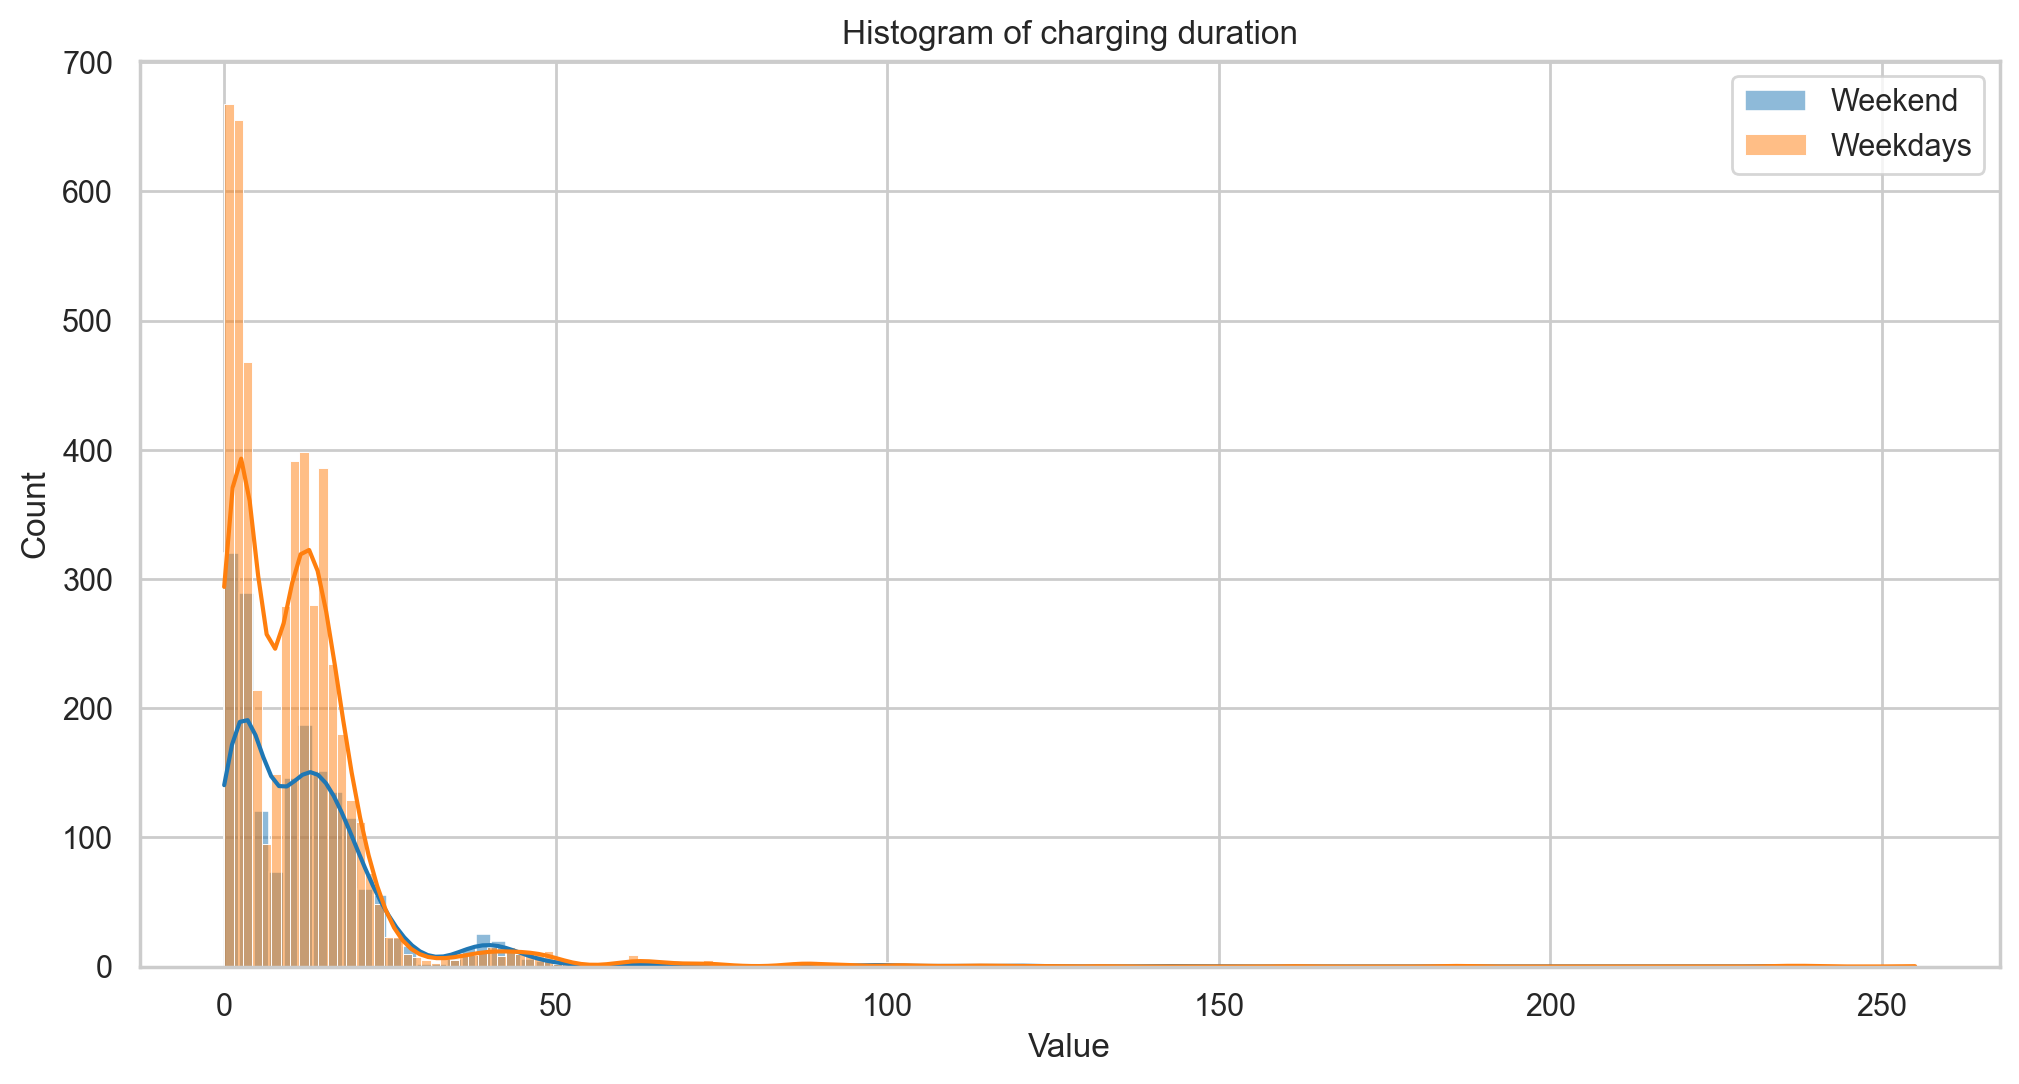

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    raw_df[(raw_df["weekdays_plugin"] == "Saturday") | (raw_df["weekdays_plugin"] == "Sunday")]["Duration_hours"],
    kde=True,
    ax=ax,
    color="#1f77b4",
    label="Weekend",
)
sns.histplot(
    raw_df[~(raw_df["weekdays_plugin"] == "Saturday") & ~(raw_df["weekdays_plugin"] == "Sunday")]["Duration_hours"],
    kde=True,
    ax=ax,
    color="#ff7f0e",
    label="Weekdays",
)
ax.set_xlabel("Value")
ax.set_title("Histogram of charging duration")
ax.legend();